In [3]:
import scipy as sc
import numpy as np
from scipy import linalg as LS
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import random

\begin{equation}
\dfrac{\partial u}{\partial t} = D\dfrac{\partial^2 u}{\partial x^2} + f(u)
\end{equation}

Si on représente u par le vecteur $(s^T\ i^T\ r^T)$ où $s,i\ et\ r$ sont des vecteurs de taille $N_x$ (pour la discrétisation spatiale), On peut alors approximer le terme de diffusion $\dfrac{\partial^2 u}{\partial x^2}$ par une application de matrice sur le vecteur u. Par exemple pour $s$ :
    
\begin{equation}
\dfrac{\partial^2 s}{\partial x^2} \approx \dfrac{1}{dx^2}
\begin{pmatrix}
s_{N_x}-2s_0 +s_1 \\
s_0-2s_1 +s_2 \\
\vdots  \\
s_{N_x -1}-2s_{N_x} +s_0
\end{pmatrix} 
 = As
\end{equation} 


Avec $A = \dfrac{1}{dx^2}tridiag(1,-2,1)$ au détail près que dans la matrice $tridiag(1,-2,1)$ on a rajouté un $1$ en $(i,j) = (0,N_x)$ et $(i,j) = (N_x,0)$, cela caractérise des conditions aux limites périodiques (hypothèse valide ?). Ainsi on peut directement approcher le vecteur $\dfrac{\partial^2 u}{\partial x^2}$ en construisant une matrice $\tilde{A}$ par assemblage : 

\begin{equation*}
\tilde{A} = 
\begin{pmatrix}
A & 0 & 0 \\
0 & A & 0 \\
0 & 0 & A
\end{pmatrix}
\end{equation*}

Et donc $\dfrac{\partial^2 u}{\partial x^2} \approx \tilde{A}u$. Dans le cadre d'une telle approxiation on peut exprimer les schémas d'Euler explicite et implicite en résolvant : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{u^{n+1}-u^n}{dt} = DAu^n + f(u^n) & \mbox{explicite } \\
        \dfrac{u^{n+1}-u^n}{dt} = DAu^{n+1} + f(u^n) & \mbox{implicite}
    \end{array}
\right.
$$

Où $u^n$ est l'approximation de la fonction spatiale $u(t = ndt,.)$. Pour le schéma implicite, on a fait le choix de ne pas écrire $f(u^{n+1})$ car dans le cas contraire on aurait à résoudre une équation bien plus complexe à chaque itération. On peut alors itérer selon l'inversion : 

$$
\left\{
    \begin{array}{ll}
        u^{n+1} = (I_{3N_x} + dtDA)u^n + dtf(u^n) & \mbox{explicite } \\
        u^{n+1} = (I_{3N_x} - dtDA)^{-1}DAu^{n} + dtf(u^n) & \mbox{implicite}
    \end{array}
\right.
$$

In [4]:
N = 1000 #effectif de la population
s0 = N   #nombre de susceptible initial
i0 = 1   #nombre d'infectés initial
r0 = 0   #nombre de guéris ou morts initial

beta = 5.  #coefficient de transmission
gamma = 1.  #coefficient de "guérison"
coef_diff = [.01,0.,.01]     #coefficient de diffusion (respectivement de s,i et r)

dt = .01
T = 10   #durée de la simulation
Nt = int(T/dt)  #nombre d'itération

dx = .01
L=1
Nx=int(L/dx)

#############répartition initiale de SIR############
u = np.zeros(3*Nx)
for x in range(Nx):
    u[x] = N*np.exp(-0.01*(x-Nx/2)**2)  #répartition des susceptibles
    u[x+Nx] = 10.*random.random()   #répartition des infectés
    u[x+2*Nx] = 0    #répartition des guéris/morts
    
#############Construction des matrices##############
B = -2*np.eye(Nx)
for i in range(Nx-1) : 
    B[i,i+1] = 1
    B[i+1,i] = 1
    
B[0,Nx-1]=1
B[Nx-1,0]=1

A = np.zeros((3*Nx,3*Nx))
D = np.zeros((3*Nx,3*Nx))

for k in range(3) : 
    A[k*Nx:(k+1)*Nx,k*Nx:(k+1)*Nx]=B
    D[k*Nx:(k+1)*Nx,k*Nx:(k+1)*Nx]=coef_diff[k]*np.eye(Nx)

A=(1/dx**2)*A   #matrice laplacien
Md=D.dot(A)

Mi = np.linalg.inv(np.eye(3*Nx)-dt*Md)  #pour implicite

#############Définition de la source##############
def f(uv):
    tab=np.zeros(3*Nx)
    for x in range(Nx) : 
        tab[x] = -beta*uv[x]*uv[x+Nx]/N
        tab[x+Nx] = beta*uv[x]*uv[x+Nx]/N -gamma*uv[x+Nx]
        tab[x+2*Nx]= gamma*uv[x+Nx]
    return tab

#Le tableau M va contenir toutes les itérations en temps du vecteur u
M = np.zeros((3*Nx,Nt)); 

#Initialisation 
M[:,0] = u; 

#############Schéma numérique##############
for t in range(1,Nt):
    #u=u + dt*(Md.dot(u)+f(u))    #explicite
    u = Mi.dot(u+dt*f(u))       #implicite (plus stable et plus "continu" que explicite)
    M[:,t]=u
    

<IPython.core.display.Javascript object>


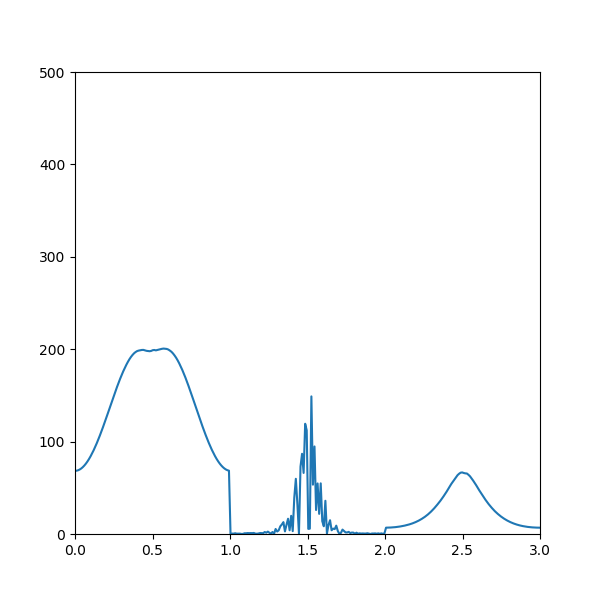

In [5]:
#############Plotting##############

esp = np.linspace(0,3*L,3*Nx)
fig, ax1 = plt.subplots(1, figsize = (6,6))
plotu,  = ax1.plot(esp,M[:,0])

def animate(p):
    f = M[:,p]
    plotu.set_ydata(f)    
    
def init(): 
    ax1.set_xlim(0,3)
    ax1.set_ylim(0.,0.5*N)
    return plotu,

step = 1
steps = np.arange(1,Nt,step)
ani = FuncAnimation(fig, animate,steps, init_func = init, interval = 10, blit = True)

Sur le graphique, S correspond à la portion [0,1], I à [1,2] et R à [2,3].

In [2]:
plt.close()

NameError: name 'plt' is not defined

Le fait d'inclure des phénomènes de diffusion au modèle a pour conséquence que chacune des fonctions s,i et r s'homogénise spatialement au cours du temps. Est-ce vraiment un modèle fidèle à la réalité ?